# Exploratory data analysis of the data from Glioma patients

---

In this notebook we will analyze PBMC data set from patient 11 obtained from blood samples taken at 3 different time points before, during and after the proton therapy treatment. The treatment takes approximately 6 weeks with multiple sessions.

The patient is 5 year old female that has embryonal rhabdomyosarcoma. At each time point 3ml blood were taken and the PBMCs were purifried, stained with DAPI, CD8 and CD4 and imaged with 16bit at a resolution of 0.09 micron in x-y direction, respectively 0.5 micron in z-direction. Each FoV is of the size of (1024x1024x40) pixels.

The data will be compared with a control data set of PBMCs purified from blood of 10 healthy volunteers of varying sex and age (24-60). In this analyses we will mainly focus on the assessment of the relative abundance of the different cell types during the treatment progression. In addition we aim to evaluate the descriptive power of the extracted morphological and chromatin organizational features for identifying the cell type.

---

## 0. Environmental setup

In [2]:
import random
import numpy as np
import pandas as pd
import sys
import os

from statannot import add_stat_annotation

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from imblearn.under_sampling import RandomUnderSampler

sys.path.append("../../../../../")
from src.utils.notebooks.eda import *
from collections import Counter

seed = 1234
random.seed(seed)
np.random.seed(seed)

%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 1. Read in data

Next, we read in the data sets that describe the PBMC population of the healthy controls as well as of patient 11 at the different time points over the course of the treatment.

In [41]:
hv_root_data_dir = "../../../../../data/control/marker/"
feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"
marker_label_file_path = "/preprocessed/full_pipeline/marker_labels/marker_labels.csv"

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
hv_data = read_in_marker_dataset(
    data_dir=hv_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
hv_data["id"] = hv_data["sample"] + hv_data["timepoint"]

Load data: 100%|██████████| 8/8 [00:00<00:00, 33.67it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [79]:
glioma_patients = ["p15", "p16", "p22", "p29", "p46", "p47", "p52", "p57"]

tp1_root_data_dir = "../../../../../data/glioma/marker/timepoint_1/"
tp2_root_data_dir = "../../../../../data/glioma/marker/timepoint_2/"
tp3_root_data_dir = "../../../../../data/glioma/marker/timepoint_3/"

tp1_features = read_in_marker_dataset(
    data_dir=tp1_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    filter_samples=glioma_patients,
    marker_label_file_path=marker_label_file_path,
)

tp2_features = read_in_marker_dataset(
    data_dir=tp2_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    filter_samples=glioma_patients,
    marker_label_file_path=marker_label_file_path,
)

tp3_features = read_in_marker_dataset(
    data_dir=tp3_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    filter_samples=glioma_patients,
    marker_label_file_path=marker_label_file_path,
)

glioma_data = tp1_features.append(tp2_features).append(tp3_features)
glioma_data["id"] = glioma_data["sample"] + glioma_data["timepoint"]

Load data: 100%|██████████| 8/8 [00:00<00:00, 27.58it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
np.unique(glioma_data.loc[:, "sample"])

array(['p15', 'p16', 'p22', 'p29', 'p46', 'p47', 'p52', 'p57'],
      dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We will randomly subsample the data from each condition to the same sample size that is the minimum number of samples in any of the conditions.

In [81]:
n_samples * len(np.unique(glioma_data.loc[:, "sample"]))

3104

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
np.random.seed(seed)
n_samples = np.min([len(hv_data)] + list(Counter(glioma_data.id).values()))

hv_data = hv_data.iloc[
    np.random.choice(
        list(range(len(hv_data))),
        replace=False,
        size=min(
            len(hv_data), n_samples * len(np.unique(glioma_data.loc[:, "sample"]))
        ),
    )
]
hv_data.describe()

,label,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,max_cd4_3d_int,mean_cd4_3d_int,std_cd4_3d_int,q25_cd4_3d_int,q75_cd4_3d_int,median_cd4_3d_int,kurtosis_cd4_3d_int,skewness_cd4_3d_int,cd8,cd4
count,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000,...,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000
mean,5.014444,59.303314,73.017842,0.814343,24.937170,37.109434,32.128255,31.882152,25.025858,29.805491,...,41505.861088,3728.960148,4555.434158,599.037383,5241.977060,1965.703696,16.821782,2.685934,0.165251,0.489805
std,3.225582,4.953307,4.957330,0.071068,3.431073,2.760090,1.866993,1.795780,3.527854,2.129399,...,21932.875534,3505.910668,3911.521653,755.815306,4983.637976,2027.412004,53.345282,1.478184,0.371486,0.500002
min,1.000000,36.000000,49.000000,0.466667,0.651100,27.790670,20.590717,18.133770,0.651100,12.240607,...,5976.000000,181.854142,447.067188,0.000000,109.000000,0.000000,1.940270,1.549567,0.000000,0.000000
25%,2.000000,56.000000,70.000000,0.767123,23.073272,35.297914,30.867415,30.633956,23.085321,28.381163,...,18682.750000,702.056587,1163.871196,0.000000,1091.000000,106.000000,4.368685,1.914095,0.000000,0.000000
50%,4.000000,59.000000,72.000000,0.819444,25.356186,36.788565,32.006332,31.781185,25.375231,29.866917,...,45540.500000,2330.103293,2993.924270,128.000000,3330.000000,1272.500000,7.729007,2.266178,0.000000,0.000000
75%,7.000000,63.000000,75.750000,0.869048,27.348310,38.455320,33.274795,32.944055,27.451344,31.169503,...,65535.000000,5734.585490,6967.818937,1045.812500,8172.625000,3251.750000,14.896221,3.057848,0.000000,1.000000
max,18.000000,74.000000,106.000000,0.970588,33.250930,55.205309,40.491774,39.347312,36.991792,37.035699,...,65535.000000,13814.772411,15442.908375,2771.500000,19564.000000,7754.000000,1433.441132,27.328589,1.000000,1.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [83]:
sampler = RandomUnderSampler(random_state=seed)
idc = np.array(list(range(len(glioma_data)))).reshape(-1, 1)
sample_idc, _ = sampler.fit_resample(idc, np.array(glioma_data.loc[:, "id"]))
glioma_data = glioma_data.iloc[sample_idc[:, 0]]
glioma_data.describe()

,label,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,mean_cd8_3d_int,std_cd8_3d_int,q25_cd8_3d_int,q75_cd8_3d_int,median_cd8_3d_int,kurtosis_cd8_3d_int,skewness_cd8_3d_int,cd16,cd4,cd8
count,9312.000000,9312.000000,9312.000000,9312.000000,9312.000000,9312.000000,9312.000000,9312.000000,9312.000000,9312.000000,...,9312.000000,9312.000000,9312.0,9312.000000,9312.000000,9312.000000,9312.000000,9312.000000,9312.000000,9312.000000
mean,9.085588,58.561104,75.548110,0.780793,23.817170,38.679488,32.248351,32.026493,23.900077,29.372170,...,1157.207973,1580.784494,0.0,99.527062,589.818245,161.783889,8.405423,0.226697,0.441259,0.401632
std,5.817738,6.011349,7.851104,0.092465,4.566800,4.374241,2.520545,2.427448,4.645606,2.709018,...,1325.259524,1211.286951,0.0,119.920442,1024.612490,366.028859,4.357438,0.418717,0.496564,0.490255
min,1.000000,15.000000,42.000000,0.150000,0.032765,20.725847,16.349413,15.635395,0.032765,11.406525,...,84.754412,258.195801,0.0,27.000000,0.000000,8.711278,2.713910,0.000000,0.000000,0.000000
25%,4.000000,55.000000,70.000000,0.725000,21.696346,35.866297,30.709732,30.551140,21.727808,27.803214,...,302.932607,735.326136,0.0,61.000000,33.000000,46.466325,5.720703,0.000000,0.000000,0.000000
50%,8.000000,59.000000,74.000000,0.794118,24.577416,37.830152,32.169192,31.939532,24.613815,29.501155,...,563.057605,1067.392844,0.0,72.000000,73.000000,92.150612,7.692754,0.000000,0.000000,0.000000
75%,13.000000,63.000000,79.000000,0.849315,26.859855,40.611037,33.704623,33.430764,26.928318,31.119867,...,1518.378105,2041.170208,0.0,98.000000,1006.625000,165.632796,9.904396,0.000000,1.000000,1.000000
max,36.000000,78.000000,133.000000,0.971429,35.608302,88.200002,46.708813,47.908657,39.929043,37.565059,...,13599.607450,11314.702986,0.0,1679.000000,10350.000000,11082.929747,78.518354,1.000000,1.000000,1.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
data = glioma_data.copy()
data["cd16"] = data["cd16"].map({0: "cd16-", 1: "cd16+"})
data["cd4"] = data["cd4"].map({0: "cd4-", 1: "cd4+"})
data["cd8"] = data["cd8"].map({0: "cd8-", 1: "cd8+"})
data["celltype"] = data["cd4"] + data["cd8"] + data["cd16"]
data.head()

,label,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,kurtosis_cd8_3d_int,skewness_cd8_3d_int,sample,timepoint,qc_pass,cd16,cd4,cd8,id,celltype
TileScan 1_Position 25_3,4,59.0,74.0,0.797297,24.752081,37.010860,30.311632,31.292630,24.752081,29.102898,...,236.827837,12.355267,p15,1,True,cd16-,cd4+,cd8-,p151,cd4+cd8-cd16-
TileScan 1_Position 4_0,1,59.0,84.0,0.702381,25.249897,42.649910,33.971706,34.162333,25.249897,30.978028,...,17.776960,3.800881,p15,1,True,cd16+,cd4-,cd8+,p151,cd4-cd8+cd16+
TileScan 1_Position 30_1,2,56.0,87.0,0.643678,23.742988,45.523140,34.430328,34.486127,23.742988,29.914883,...,188.731002,10.645076,p15,1,True,cd16-,cd4+,cd8-,p151,cd4+cd8-cd16-
TileScan 1_Position 29_5,6,67.0,74.0,0.905405,28.562426,38.599460,33.620756,33.682122,28.562426,32.897501,...,69.895932,6.849604,p15,1,True,cd16-,cd4-,cd8-,p151,cd4-cd8-cd16-
TileScan 1_Position 25_12,13,59.0,73.0,0.808219,26.101987,36.401576,31.590173,31.715535,26.101987,30.134355,...,188.231934,10.696065,p15,1,True,cd16-,cd4-,cd8-,p151,cd4-cd8-cd16-


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

## 2. Dimensionality reduction

Next, we will clean the data and remove samples with missing values, constant features as well as those samples that were flagged for not passing our quality checks.

In [85]:
data = preprocess_data(data)
sample_labels = data.loc[:, "sample"]
condition_labels = data.loc[:, "timepoint"]
celltype_label = data.loc[:, "celltype"]

Nuclei that did not pass the quality check: 498/9312. Remaining: 8814.
Removed 20 constant or features with missing values. Remaining: 283.
Removed additional 6 features. Remaining: 277.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [119]:
features = data._get_numeric_data().iloc[:, :-2]
nmco_features = features.copy()
nmco_features = nmco_features.loc[:, ~nmco_features.columns.str.contains("cd8")]
nmco_features = nmco_features.loc[:, ~nmco_features.columns.str.contains("cd4")]
nmco_features = nmco_features.loc[:, ~nmco_features.columns.str.contains("dna")]
nmco_features = nmco_features.loc[:, ~nmco_features.columns.str.contains("cd16")]
nmco_features.head()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,d75_radius,...,nuclear_mean_int,nuclear_std_int,rdp_1,rdp_2,rdp_3,rdp_4,rdp_5,rdp_6,rdp_7,rdp_8
TileScan 1_Position 25_3,59.0,74.0,0.797297,24.752081,37.010860,30.311632,31.292630,24.752081,29.102898,34.362975,...,20533.565337,8288.174620,0.006606,0.024718,0.054337,0.120024,0.213213,0.333906,0.538533,0.760565
TileScan 1_Position 4_0,59.0,84.0,0.702381,25.249897,42.649910,33.971706,34.162333,25.249897,30.978028,37.843002,...,23433.934237,9271.006128,0.000047,0.003405,0.020003,0.065254,0.153483,0.308846,0.508965,0.749439
TileScan 1_Position 30_1,56.0,87.0,0.643678,23.742988,45.523140,34.430328,34.486127,23.742988,29.914883,38.487908,...,20405.325386,9038.690951,0.007971,0.027798,0.059482,0.123567,0.214185,0.331337,0.539109,0.761997
TileScan 1_Position 29_5,67.0,74.0,0.905405,28.562426,38.599460,33.620756,33.682122,28.562426,32.897501,34.562875,...,18746.941629,7972.163246,0.001234,0.010459,0.027676,0.090217,0.192290,0.333896,0.553752,0.775787
TileScan 1_Position 25_12,59.0,73.0,0.808219,26.101987,36.401576,31.590173,31.715535,26.101987,30.134355,33.499123,...,22945.830547,9289.506810,0.002623,0.014009,0.034160,0.094989,0.189152,0.316649,0.534739,0.762522


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Finally, we will reduce the dimensionality of the data set further by removing highly correlated features ($\rho > 0.8$).

In [120]:
nmco_features = features = remove_correlated_features(nmco_features, threshold=0.8)

Removed 155/204 features with a Pearson correlation above 0.8. Remaining: 49


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

There are 58 features that remain which have correlation of less than 0.8 to any other features.

---

## 3. Data visualization

Next, we will visualize the data set using TSNE. To this end, we will first z-score the data.

In [121]:
nmco_features_sc = pd.DataFrame(
    StandardScaler().fit_transform(nmco_features),
    index=nmco_features.index,
    columns=nmco_features.columns,
)
nmco_features_sc.describe()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,med_radius,concavity,area_bbarea,avg_curvature,std_curvature,npolarity_changes,...,weighted_moments_central-2-3,weighted_moments_central-3-2,moments_normalized-0-2,moments_normalized-2-0,moments_central-0-1,moments_central-1-0,equivalent_diameter.1,extent,rel_hc_volume,rdp_1
count,8.814000e+03,8.814000e+03,8.814000e+03,8.814000e+03,8.814000e+03,8.814000e+03,8.814000e+03,8.814000e+03,8.814000e+03,8.814000e+03,...,8.814000e+03,8.814000e+03,8.814000e+03,8.814000e+03,8.814000e+03,8.814000e+03,8.814000e+03,8.814000e+03,8.814000e+03,8.814000e+03
mean,-5.546329e-16,4.341131e-16,3.272979e-16,4.530577e-16,6.513711e-16,-7.255372e-17,-1.588120e-16,1.138287e-15,2.579688e-16,-3.272979e-16,...,-8.061524e-19,3.023072e-18,-6.666880e-16,7.682632e-16,-1.108460e-17,8.061524e-18,-2.295922e-15,-1.741289e-16,-2.889250e-15,3.164148e-17
std,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,...,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00
min,-5.203322e+00,-3.660930e+00,-4.772477e+00,-5.544907e+00,-6.454896e+00,-1.304686e+00,-1.094034e+01,-1.063428e+01,-2.313593e+00,-3.152775e+00,...,-3.637746e+01,-4.229042e+01,-2.744393e+00,-2.811681e+00,-5.412324e+00,-4.011504e+00,-7.856840e+00,-7.890391e+00,-1.860614e+01,-9.407814e-01
25%,-6.595632e-01,-6.090460e-01,-6.125684e-01,-4.960669e-01,-6.668955e-01,-6.150010e-01,-5.341706e-01,-5.296988e-01,-7.003412e-01,-6.604931e-01,...,-1.843410e-01,-1.784529e-01,-6.171576e-01,-6.459408e-01,-6.135661e-01,-6.913751e-01,-6.845327e-01,-5.622243e-01,-6.026092e-01,-7.758058e-01
50%,3.947664e-02,-2.109741e-01,1.295870e-01,1.560474e-01,-5.022712e-02,-2.593184e-01,1.253889e-01,9.081887e-02,-9.865835e-02,-8.535121e-02,...,1.104537e-02,-1.696734e-03,-1.260146e-01,-1.185387e-01,-1.430443e-04,-6.385766e-03,3.665132e-03,8.723411e-02,6.620215e-03,-3.137690e-01
75%,7.385165e-01,4.524789e-01,7.452706e-01,6.731931e-01,5.996123e-01,3.184627e-01,6.658135e-01,6.132081e-01,5.891660e-01,5.856477e-01,...,2.000362e-01,1.914824e-01,4.649851e-01,4.890788e-01,6.255605e-01,6.755447e-01,5.924429e-01,6.834026e-01,6.210585e-01,4.369196e-01
max,3.359916e+00,7.617771e+00,2.075075e+00,2.513969e+00,6.189637e+00,2.570635e+01,3.324565e+00,1.045385e+01,1.096504e+01,1.611448e+01,...,3.255684e+01,2.307345e+01,2.598553e+01,1.087567e+01,6.539043e+00,4.081934e+00,5.134088e+00,3.291644e+00,4.276582e+00,9.388411e+00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Next, we compute the TSNE.

In [122]:
tsne = TSNE(random_state=seed)
tsne_embs = tsne.fit_transform(nmco_features_sc)
tsne_embs = pd.DataFrame(
    tsne_embs, columns=["tsne_0", "tsne_1"], index=nmco_features_sc.index
)
tsne_embs.loc[:, "sample"] = np.array(data.loc[tsne_embs.index, "sample"])
tsne_embs.loc[:, "timepoint"] = np.array(data.loc[tsne_embs.index, "timepoint"])

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

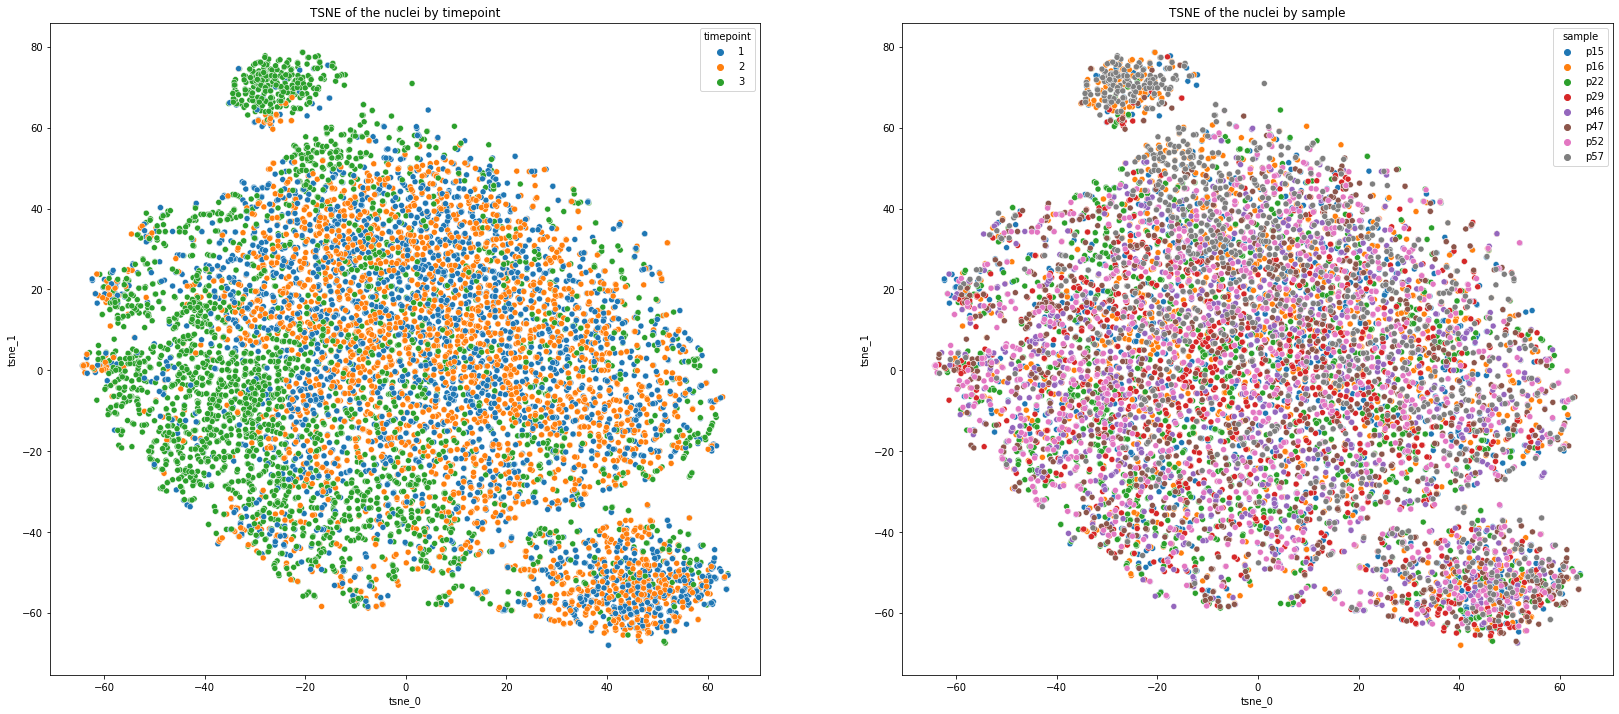

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [123]:
tmp_embs = tsne_embs.loc[tsne_embs.loc[:, "timepoint"].isin(["1", "2", "3"])]
fig, ax = plt.subplots(figsize=[28, 12], ncols=2)
ax = ax.flatten()
ax[0] = sns.scatterplot(
    data=tmp_embs,
    x="tsne_0",
    y="tsne_1",
    hue="timepoint",
    ax=ax[0],
)
ax[0].set_title("TSNE of the nuclei by timepoint")
tmp_embs.loc[(tmp_embs["timepoint"] == "ctrl"), "sample"] = "hvs"
ax[1] = sns.scatterplot(
    data=tmp_embs,
    x="tsne_0",
    y="tsne_1",
    hue="sample",
    ax=ax[1],
)
ax[1].set_title("TSNE of the nuclei by sample")
plt.show()

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


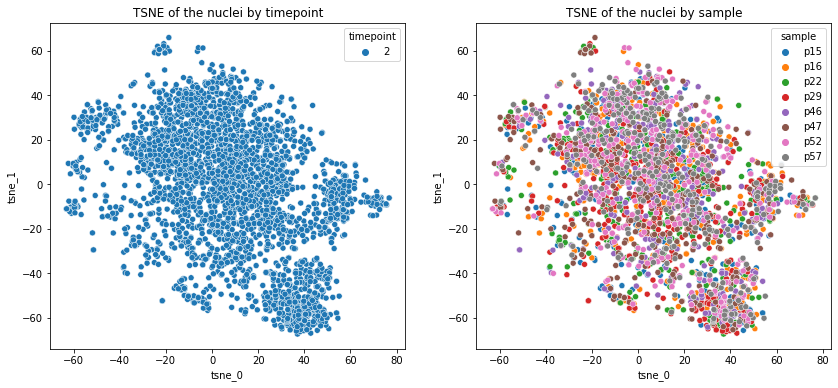

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [91]:
tmp_embs = tsne_embs.loc[tsne_embs.loc[:, "timepoint"].isin(["ctrl", "2"])]
fig, ax = plt.subplots(figsize=[14, 6], ncols=2)
ax = ax.flatten()
ax[0] = sns.scatterplot(
    data=tmp_embs,
    x="tsne_0",
    y="tsne_1",
    hue="timepoint",
    ax=ax[0],
)
ax[0].set_title("TSNE of the nuclei by timepoint")
tmp_embs.loc[(tmp_embs["timepoint"] == "ctrl"), "sample"] = "hvs"
ax[1] = sns.scatterplot(
    data=tmp_embs,
    x="tsne_0",
    y="tsne_1",
    hue="sample",
    ax=ax[1],
)
ax[1].set_title("TSNE of the nuclei by sample")
plt.show()

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


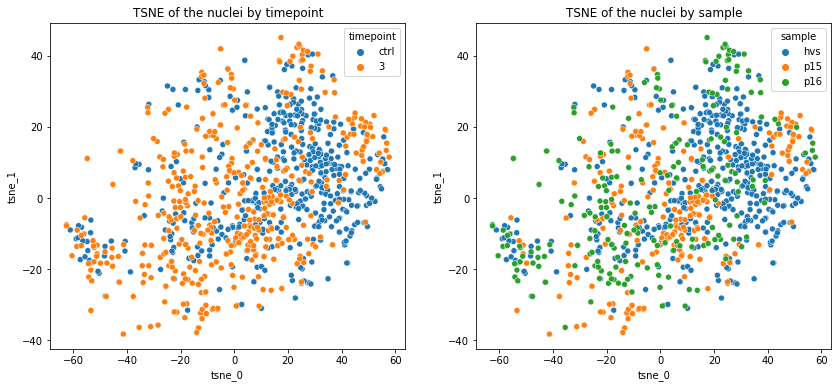

<IPython.core.display.Javascript object>

In [20]:
tmp_embs = tsne_embs.loc[tsne_embs.loc[:, "timepoint"].isin(["ctrl", "3"])]
fig, ax = plt.subplots(figsize=[14, 6], ncols=2)
ax = ax.flatten()
ax[0] = sns.scatterplot(
    data=tmp_embs,
    x="tsne_0",
    y="tsne_1",
    hue="timepoint",
    ax=ax[0],
)
ax[0].set_title("TSNE of the nuclei by timepoint")
tmp_embs.loc[(tmp_embs["timepoint"] == "ctrl"), "sample"] = "hvs"
ax[1] = sns.scatterplot(
    data=tmp_embs,
    x="tsne_0",
    y="tsne_1",
    hue="sample",
    ax=ax[1],
)
ax[1].set_title("TSNE of the nuclei by sample")
plt.show()

---

## Cell type abundances

In [21]:
data["timepoint"]

TileScan 1_Position 25_3       1
TileScan 1_Position 4_0        1
TileScan 1_Position 30_1       1
TileScan 1_Position 29_5       1
TileScan 1_Position 25_12      1
                              ..
TileScan 1_Position 24_13_7    3
TileScan 1_Position 24_5_11    3
TileScan 1_Position 20_14_8    3
TileScan 1_Position 13_6_13    3
TileScan 1_Position 16_5_12    3
Name: timepoint, Length: 8814, dtype: object

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

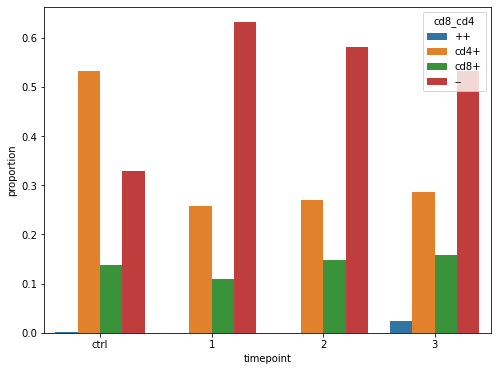

<IPython.core.display.Javascript object>

In [38]:
fig, ax = plt.subplots(figsize=[8, 6])
x, y, hue = "timepoint", "proportion", "cd8_cd4"
hue_order = ["++", "cd4+", "cd8+", "--"]

l = (
    data[x]
    .sort_values(ascending=True)
    .groupby(data[hue])
    .value_counts()
    .rename(y)
    .reset_index()
)
for cond in np.unique(l["timepoint"]):
    l.loc[l["timepoint"] == cond, "proportion"] /= np.sum(
        l.loc[l["timepoint"] == cond, "proportion"]
    )
l.pipe(
    (sns.barplot, "data"),
    x=x,
    y=y,
    hue=hue,
    order=["ctrl", "1", "2", "3"],
    hue_order=hue_order,
    ax=ax,
)
plt.show()

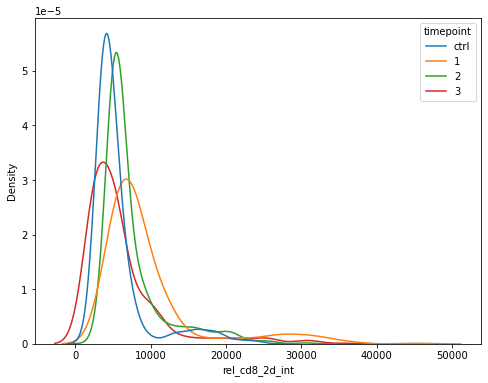

<IPython.core.display.Javascript object>

In [40]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.kdeplot(data=data, x="rel_cd8_2d_int", hue="timepoint", ax=ax)
plt.show()

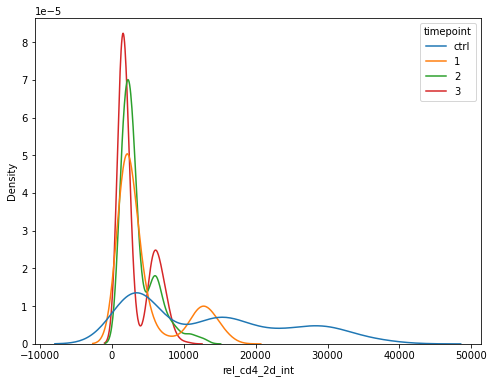

<IPython.core.display.Javascript object>

In [41]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.kdeplot(data=data, x="rel_cd4_2d_int", hue="timepoint", ax=ax)
plt.show()

In [101]:
tmp.timepoint

TileScan 1_Position 25_3                               1
TileScan 1_Position 4_0                                1
TileScan 1_Position 30_1                               1
TileScan 1_Position 29_5                               1
TileScan 1_Position 25_12                              1
                                                    ... 
HV2_PBMCs_Dapi_CD8_CD4_28_07_21_2X_16bit_2X_33_1    ctrl
HV3_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_12_2    ctrl
HV8_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_10_8    ctrl
HV6_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_13_5    ctrl
HV8_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_13_0    ctrl
Name: timepoint, Length: 11168, dtype: object

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

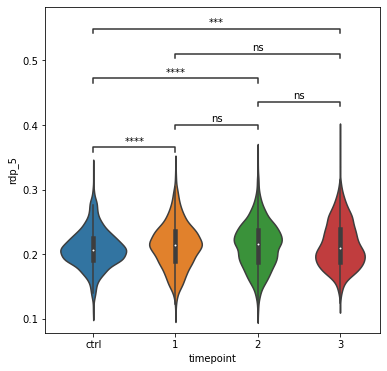

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [118]:
tmp = data.copy().append(hv_data)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6, 6])
ax = sns.violinplot(
    data=tmp, x="timepoint", y="rdp_5", ax=ax, order=["ctrl", "1", "2", "3"]
)
add_stat_annotation(
    ax,
    data=tmp,
    x="timepoint",
    y="rdp_5",
    box_pairs=[
        ("ctrl", "1"),
        ("ctrl", "2"),
        ("ctrl", "3"),
        ("1", "2"),
        ("1", "3"),
        ("2", "3"),
    ],
    test="Mann-Whitney",
    order=["ctrl", "1", "2", "3"],
    loc="inside",
    verbose=0,
)
plt.show()

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix
from src.utils.notebooks.eda import *

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [125]:
features = np.array(nmco_features_sc)
labels = np.array(data.loc[nmco_features_sc.index, "timepoint"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [126]:
rfc = RandomForestClassifier(n_estimators=500, n_jobs=10, random_state=seed)
skf = StratifiedKFold(10)


confusion_mtx = np.zeros([3, 3])
for train_index, test_index in skf.split(features, labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    rfc.fit(X_train, y_train)
    confusion_mtx += confusion_matrix(y_test, rfc.predict(X_test), normalize="true")
confusion_mtx /= 10

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

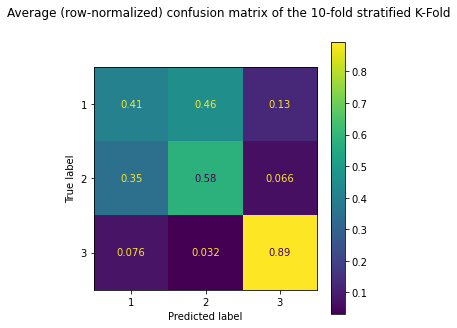

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [127]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    confusion_mtx,
    display_labels=["1", "2", "3"],
)
disp.plot(ax=ax)
fig.suptitle(
    "Average (row-normalized) confusion matrix of the 10-fold stratified K-Fold"
)
plt.show()

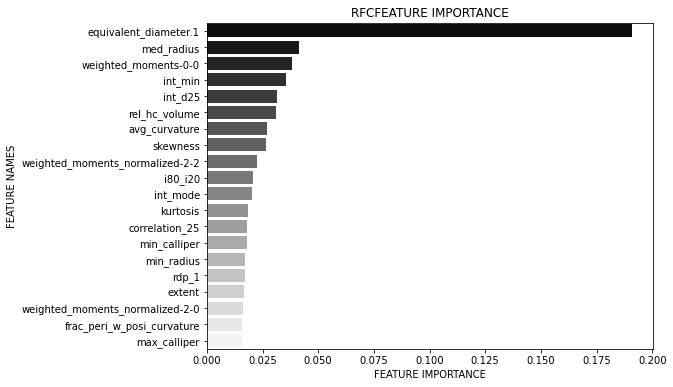

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [128]:
rfc = rfc.fit(features, labels)
plot_feature_importance(rfc.feature_importances_, nmco_features_sc.columns, "RFC")